<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/EsmeBarkU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm


In basketball, players can rebound when they gain posession of the ball after a player attempts and misses a shot. Different players play different positions, meaning they spend more time on different parts of the court and have different goals. As a result, players in different positions get different amounts of rebounds. The goal of this project is to predict how many rebounds players will get based on their positions.

Below is the data containing statistics about 572 professional basketball players in the 2023-2024 season.

In [4]:
basketball_url = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
bball_data = pd.read_csv(basketball_url)
bball_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


Using that data, I generated a violin plot of the number of rebounds different positions get. The goal of this was to get some idea of where the means are and what the deviation is like for my priors. Based on this information, I estimated the mean to be around 200 rebounds.

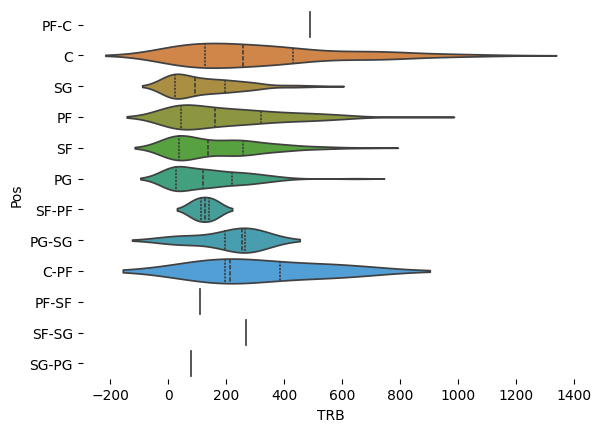

In [ ]:
sns.violinplot(bball_data, x='TRB', y='Pos', inner='quart',hue='Pos')
sns.despine(top=True, right=True, bottom=True, left=True)

Next, I stored the positions as numbers in a numpy array, and made that array an item in a dictionary called bball_coords.

In [5]:
bball_encode = pd.Categorical(bball_data['Pos'])
bball_idx = bball_encode.codes
bball_coords = {"Pos": bball_encode.categories}

With all that out of the way, I made the hierarchical model. I used a StudentT distribution for my prior, since I needed a slightly more flexible model with potentially heavier tails. I used normal distributions for most of my hyperpriors, since I don't know much about basketball and it seemed to work fine when I tested it. However, I used a StudentT distribution for hyper mean, since the means seemed to lean more below 200 than above.

In [ ]:
with pm.Model(coords=bball_coords) as bball_h_model:
    # gemeni helped me fix up some of the specifics within each prior
    mu_hyper_mean = pm.StudentT('mu_hyper_mean', nu=559, mu=200, sigma=50)
    nu_hyper_df = pm.HalfNormal('nu_hyper_df', sigma=20)

    μ_p = pm.Normal('mu_pos', mu=mu_hyper_mean, sigma=nu_hyper_df, dims="Pos")
    ν_p = pm.HalfNormal('nu_pos', sigma=nu_hyper_df, dims="Pos")

    sigma_obs = pm.Exponential('sigma_obs', lam=1/559)

    trb_data = bball_data['TRB'].values

    y = pm.StudentT('y', mu=μ_p[bball_idx], nu=ν_p[bball_idx], sigma=sigma_obs, observed=trb_data)

    idata_bball = pm.sample(target_accept=0.95)

Based on the graphs below, it seems like this model did a pretty good job of predicting the rebounds per position

array([[<Axes: title={'center': 'mu_hyper_mean'}>,
        <Axes: title={'center': 'mu_hyper_mean'}>],
       [<Axes: title={'center': 'mu_pos'}>,
        <Axes: title={'center': 'mu_pos'}>],
       [<Axes: title={'center': 'nu_hyper_df'}>,
        <Axes: title={'center': 'nu_hyper_df'}>],
       [<Axes: title={'center': 'nu_pos'}>,
        <Axes: title={'center': 'nu_pos'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>]], dtype=object)

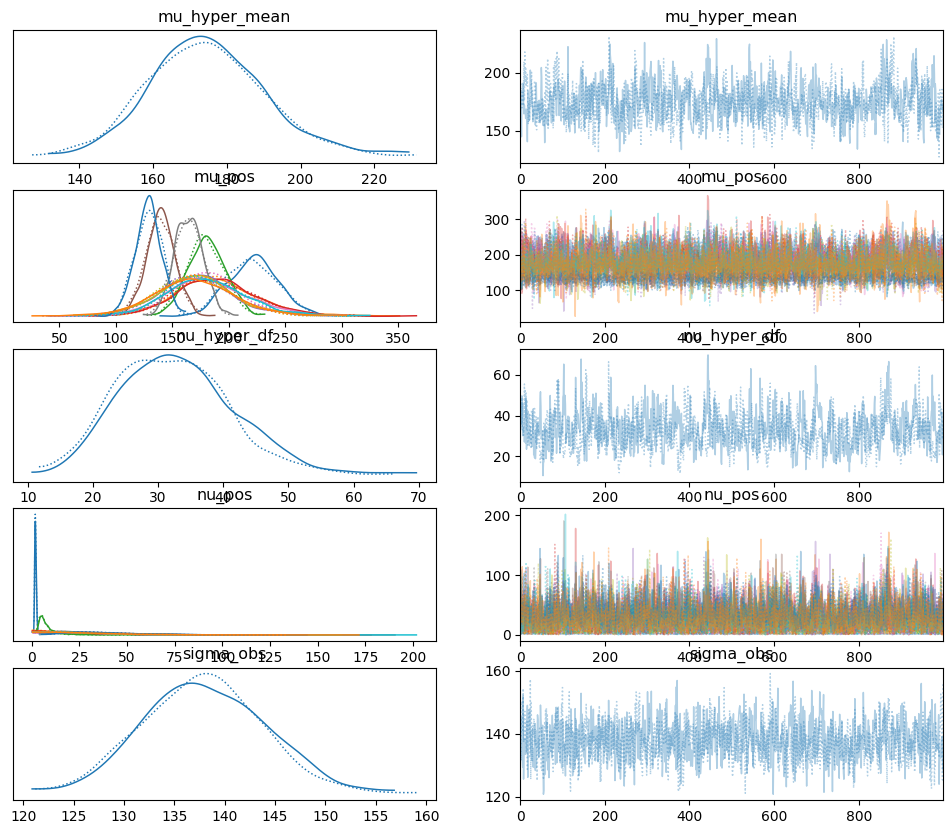

In [7]:
az.plot_trace(idata_bball)

The rhat values confirm this.

In [ ]:
az.rhat(idata_bball)

To end the project, I used my posterior to graph the mean amount of rebounds for all basketball positions.

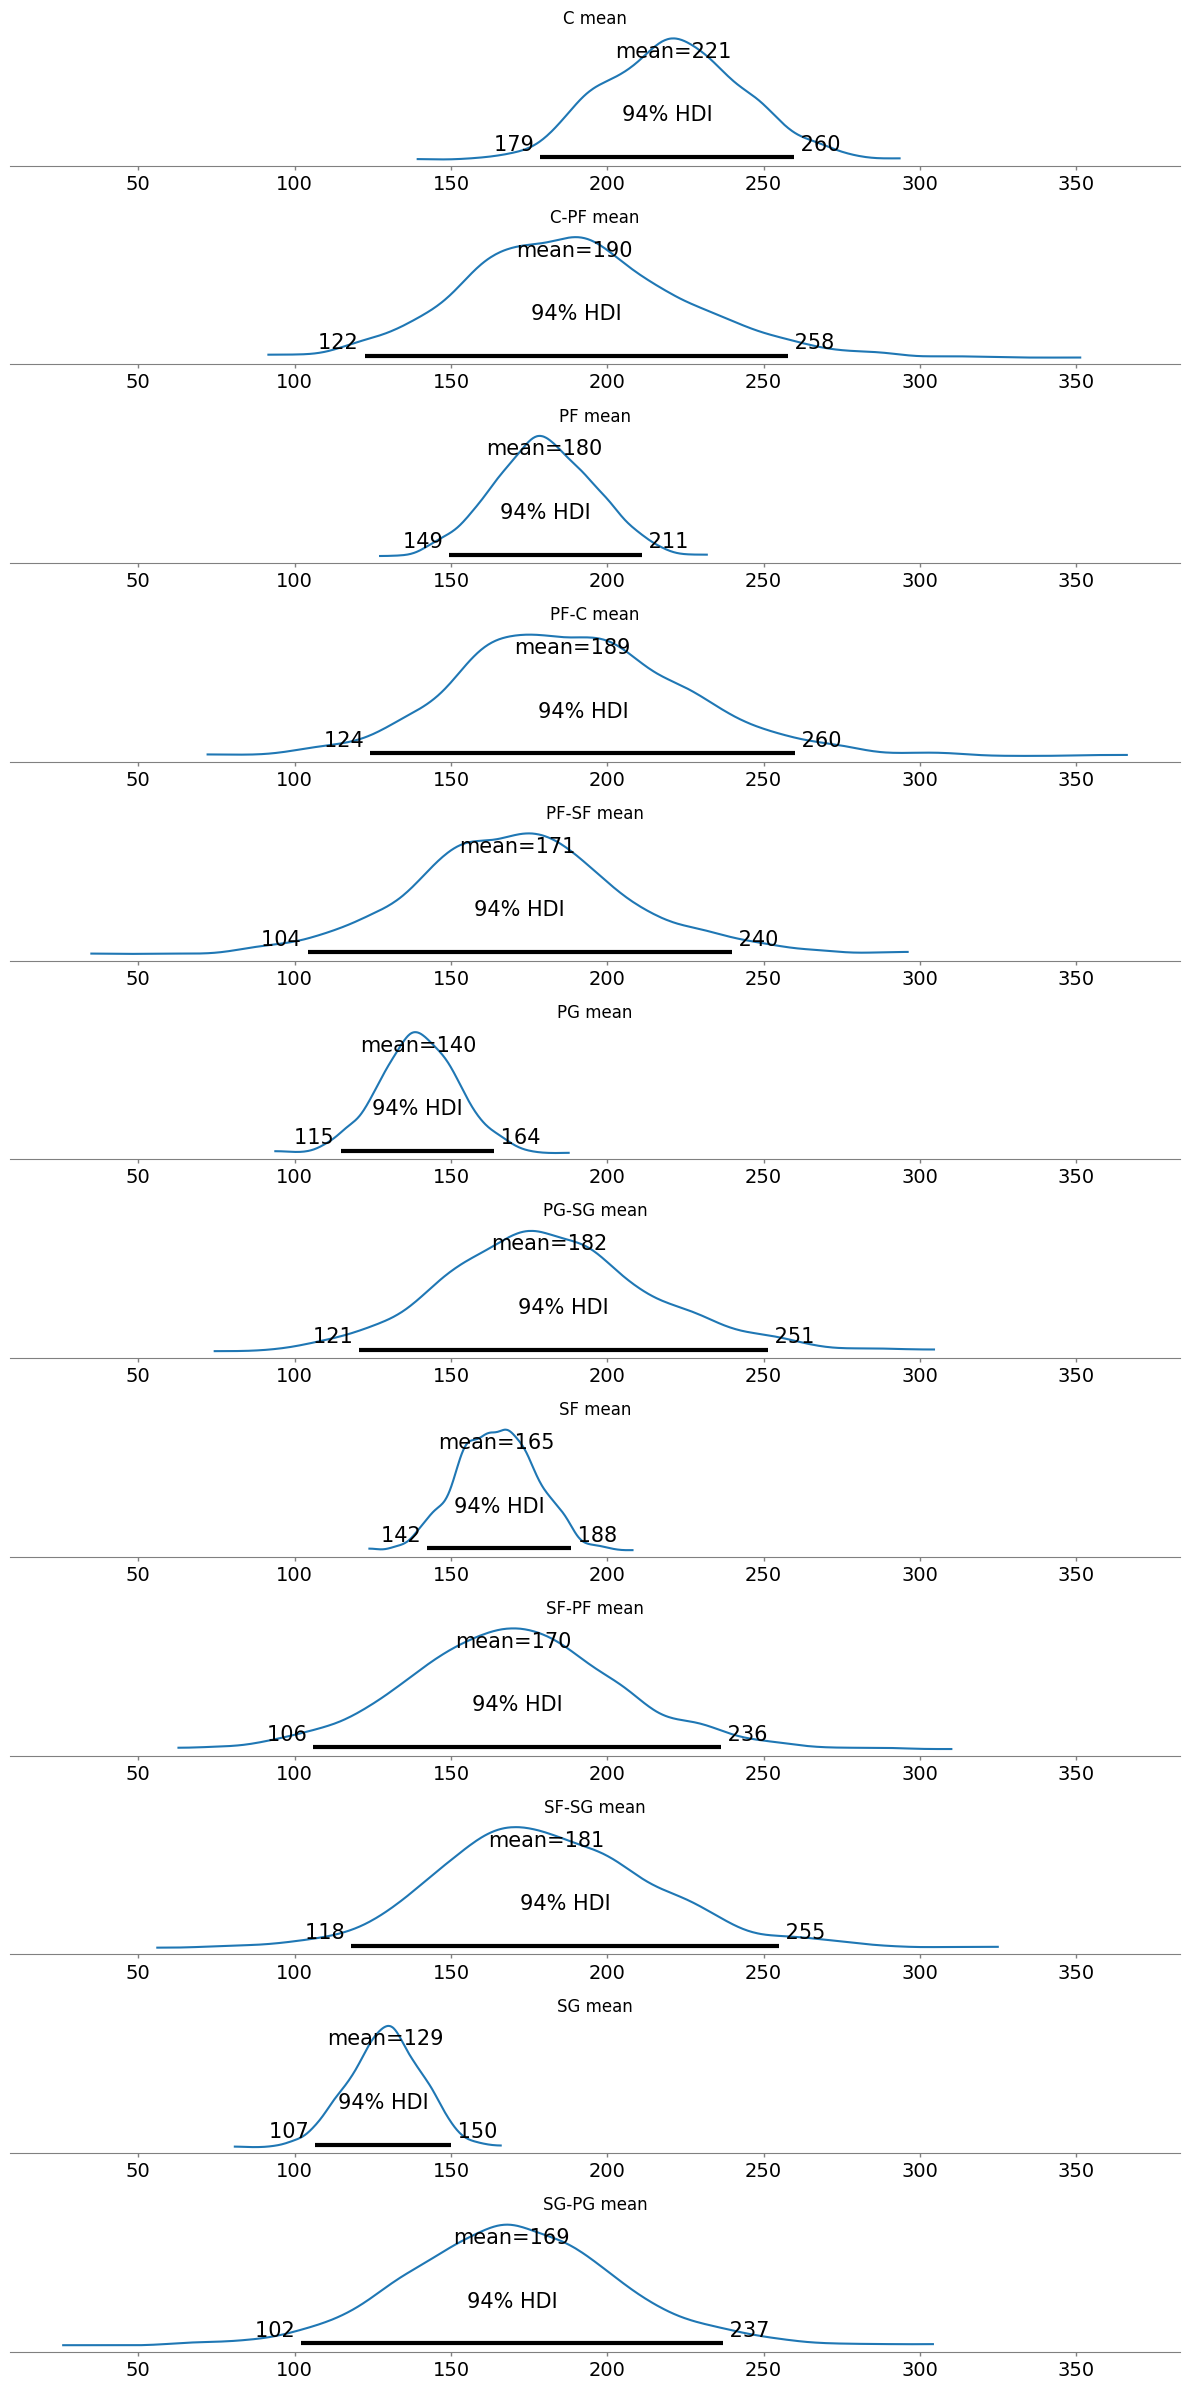

In [8]:
positions = bball_coords['Pos'].values
fig, axes = plt.subplots(len(positions), 1, figsize=(12, len(positions)*2), sharex=True)

for i, pos_name in enumerate(positions):
    az.plot_posterior(idata_bball.posterior.sel(Pos=pos_name), var_names='mu_pos', ax=axes[i])
    axes[i].set_title(f"{pos_name} mean")

plt.tight_layout()

I don't know much about basketball, but based off of what I can see in the data these numbers seem believable to me. The project could probably be improved if I knew more about the sport and was able to filter my data(if it needs filtering) or choose more accurate priors.